<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/downloadDicomAndConvertAndInferenceTotalSegmentatorNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook does the first and second steps in the split workflow on Terra

DICOM files are downloaded and converted to NIFTI files. NIFTI files are provided as input for Inference.


Please cite:

Jakob Wasserthal, Manfred Meyer, Hanns-Christian Breit, Joshy Cyriac, Shan Yang, & Martin Segeroth. (2022). TotalSegmentator: robust segmentation of 104 anatomical structures in CT images. https://doi.org/10.48550/arXiv.2208.05868

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nat Methods 18, 203–211 (2021). https://doi.org/10.1038/s41592-020-01008-z

###Installing Packages

In [ ]:
# %%capture
# #Installing lz4 for compression/decompression; dcm2niix and plastimatch for conversion; 
# #xvfb required for previewing Totalsegmentator png images
# !apt-get install lz4 xvfb dcm2niix pigz plastimatch ffmpeg

In [ ]:
# %%capture
# #Installing Totalsegmentator for Inference
# #pyradiomics required for extracting radiomics features 
# #nvidia-ml-py3 for capturing gpu utilization
# !pip install TotalSegmentator pyradiomics nvidia-ml-py3

In [ ]:
# %%capture
# #install s5cmd
# !wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
# !tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !mv s5cmd /usr/local/bin/s5cmd

###Importing Packages

In [ ]:
import os
import sys
import time
import pandas as pd
from pathlib import Path
import shutil
import glob
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import matplotlib.pyplot as plt
import nvidia_smi
import subprocess

In [ ]:
curr_dir   = Path().absolute()

os.environ['TZ'] = 'US/Eastern'
time.tzset()
current_time = time.strftime('%a %b %d %H:%M:%S %Y', time.localtime())
print(current_time)
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Thu May 04 14:43:57 2023

Current directory :/content
Python version    : 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


###Parameters for papermill

In [ ]:
converterType='dcm2niix'
csvFilePath=''

###**Local testing**

In [ ]:
# !wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
# csvFilePath =glob.glob('*.csv')[0]

###Reading CSV File containing s5cmd Urls

In [ ]:
#get the path of the zip file containing csv file in the current working directory3
#In Terra, a zip file containing the csv file will be provided as input and will be localized
#to the current working directory.


#zip_file_path='/content/drive/MyDrive/result.zip'
#!unzip $zip_file_path

#csv_file_path= '/home/vamsi/Downloads/result.csv'
#csvFilePath=csvFilePath.replace("gs://", "/cromwell_root/")

start_time = time.time()
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
#cohort_df= pd.read_csv('/content/drive/MyDrive/bquxjob_7f0d87d5_187056e0dd3.csv') #two nifti files example
#cohort_df= pd.read_csv('/content/drive/MyDrive/idc/bq-results-20230315-160529-1678896367937.csv')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')

read in 0.011936187744140625  seconds


In [ ]:
SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()
#SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()
#SeriesInstanceUIDs=[ '1.3.6.1.4.1.14519.5.2.1.7009.9004.946109466334058509440732472138',
# '1.2.840.113654.2.55.99651797089556982668213819691341139949'  
# ]

###Defining Functions

In [ ]:
#Creating Directories for conversion
if converterType.lower()=='dcm2niix':
  try:
    shutil.rmtree('dcm2niix')
  except OSError:
    pass
  os.mkdir('dcm2niix')
else:
  try:
    shutil.rmtree('plastimatch')
  except OSError:
    pass
  os.mkdir('plastimatch')

In [ ]:
#create directory for TotalSegmentator Output files

try:
  shutil.rmtree('Inference')
  shutil.rmtree('metadata')
except OSError:
  pass
os.mkdir('Inference')
os.mkdir('metadata')

In [ ]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.
  """
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  #!cat 

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [ ]:
def convert_dicom_to_nifti(series_id):
  
  if converterType.lower()=='dcm2niix':
    try:
      shutil.rmtree(f'dcm2niix/{series_id}')
    except OSError:
      pass
    os.mkdir(f'dcm2niix/{series_id}')

    !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o  /{curr_dir}/dcm2niix/{series_id}  /{curr_dir}/idc_data/
  else:
    try:
      shutil.rmtree(f'plastimatch/{series_id}')
    except OSError:
      pass
    os.mkdir(f'plastimatch/{series_id}')
    """
    Make sure to check the s5cmd urls for the destination directory and 
    plastimatch input directory must be changed accordingly
    dcm2niix, however, checks upto depth 5 to find DICOM files

    """
    !plastimatch convert --input /{curr_dir}/idc_data/{series_id} --output-img /{curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz


  try:
      shutil.rmtree('idc_data')
  except OSError:
      pass
  os.mkdir('idc_data')

In [ ]:
def check_dicom_conversion_errors(series_id_folder_path):
    nifti_files = os.listdir(series_id_folder_path)
    if len(nifti_files) > 1:
        with open('error_file.txt', 'a') as f:
            f.write(f"Error: More than one file in {series_id_folder_path}\n")
        return True
    else:
        return False

In [ ]:
def check_total_segmentator_errors(series_id):
    try:
        # Check if the output files from TotalSegmentator exist
        assert os.path.exists(f"{curr_dir}/Inference/{series_id}/segmentations.nii")
        # assert os.path.exists(f"{curr_dir}/Inference/{series_id}/statistics_radiomics.json")
        # assert os.path.exists(f"{curr_dir}/Inference/{series_id}/preview_total.png")
    except AssertionError:
        # If any of the output files do not exist, log an error
        with open('totalsegmentator_errors.txt', 'a') as f:
            f.write(f"Error: TotalSegmentator failed for series {series_id}\n")
        return True
    return False

In [ ]:
def inferenceTotalSegmentator(series_id):

      start_time = time.time()
      download_dicom_data(series_id)
      dicom_download_time = time.time() - start_time      

      start_time = time.time()
      convert_dicom_to_nifti(series_id)
      dicom_conversion_time = time.time() - start_time     

      try:
        shutil.rmtree(f'Inference/{series_id}')
        shutil.rmtree(f'metadata/{series_id}')
        os.remove('segmentations.nii.gz')
        os.remove('statistics_radiomics.json')
        os.remove('preview_total.png')
      except OSError:
        pass
      os.mkdir(f'Inference/{series_id}')

      print("Processing series: "+series_id)  


      series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      nifti_files = os.listdir(series_id_folder_path)
      # Get the first (and only) file in the list
      nifti_filename = nifti_files[0]
      # Get the full path of the file
      nifti_filename_path = os.path.join(series_id_folder_path, nifti_filename)
      
      if not check_dicom_conversion_errors(series_id_folder_path):

        start_time = time.time()
        #!TotalSegmentator -i {nifti_filename_path} -o segmentations --ml --fast --preview  --radiomics 
        result=subprocess.run(['TotalSegmentator', '-i', nifti_filename_path, '-o', 'segmentations', '--ml'],stdout=subprocess.PIPE, stderr=subprocess.PIPE,  universal_newlines=True)
        print(result.stdout)
        total_segmentator_time = time.time() - start_time

        try:
          subprocess.run(["mv", f"{curr_dir}/segmentations.nii", f"{curr_dir}/Inference/{series_id}/"], check=True)
          print("Files moved successfully using the first command")
        except subprocess.CalledProcessError:
          try:
            subprocess.run(["mv", "segmentations/segmentations.nii", f"{curr_dir}/Inference/{series_id}/"], check=True)
            print("Files moved successfully using the second command")
          except subprocess.CalledProcessError:
                print("Error: Failed to move files using both commands")

        check_total_segmentator_errors(series_id)
        
        #!mv {curr_dir}/preview_total.png {curr_dir}/segmentations.nii {curr_dir}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/
        !mv {curr_dir}/Inference/{series_id}/segmentations.nii {curr_dir}/Inference/{series_id}/{series_id}.nii
        # !mv {curr_dir}/Inference/{series_id}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json      
        # !mv {curr_dir}/Inference/{series_id}/preview_total.png {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png

        start_time = time.time()  
        !lz4 --rm {curr_dir}/Inference/{series_id}/{series_id}.nii {curr_dir}/Inference/{series_id}/{series_id}.nii.lz4
        #!tar cvf - -C {curr_dir}/Inference/{series_id} {series_id}_statistics_radiomics.json {series_id}_preview_total.png | lz4  > metadata/{series_id}_metadata.tar.lz4
        archiving_time = time.time() - start_time

      else: 
        total_segmentator_time=0
        archiving_time=0

      
      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 

      log['dicom_download_time']=dicom_download_time
      log['dicom_conversion_time']=dicom_conversion_time            
      log['total_segmentator_time']=total_segmentator_time
      log['archiving_time'] = archiving_time

      !rm -r {curr_dir}/{converterType}/{series_id}
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

In [ ]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True
        self.working_disk_path = self.get_working_disk_path()

    def get_working_disk_path(self):
        partitions = psutil.disk_partitions()
        for partition in partitions:
            if partition.mountpoint == '/':
                return '/'
            elif '/cromwell_root' in partition.mountpoint:
                return '/cromwell_root'
        return '/'  # Default to root directory if no specific path is found
    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_usage = psutil.disk_usage(self.working_disk_path)
            disk_used = disk_usage.used / 1024 / 1024 / 1024
            disk_total = disk_usage.total / 1024 / 1024 / 1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total

###Total Segmentator

Copying files from IDC buckets..
Done in 2.61175 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 38 DICOM file(s)
Dims 512 512 38 1 1
 Distance from first slice:
dx=[0 1.80005 3.59998 5.40002 7.19995 9 10.8 12.6 14.4 16.2 18 19.8 21.6 23.4 25.2 27 28.8 30.6 32.4 35.8757 37.5956 39.3225 41.0559 42.7946 44.5383 46.2864 48.0381 49.7934 51.5517 53.3129 55.0766 56.8424 58.6104 60.3803 62.1519 63.9252 65.6998 67.4758]
Convert 38 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.172787163177205374234578117444/1.3.6.1.4.1.14519.5.2.1.7009.9004.17278716317720537423457811744_1_OPA_PH_MX8000_C_300_2_120_45_30_1.5_20000102000000_3892 (512x512x38x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.172787163177205374234578117444/1.3.6.1.4.1.14519.5.2.1.7009.9004.17278716317720537423457811744_1_OPA_PH_MX8000_C_300_2_120_45_30_1.5_20000102000000_3892.nii"
compress: "/usr/bin/pigz" -n -f -6 "//conte

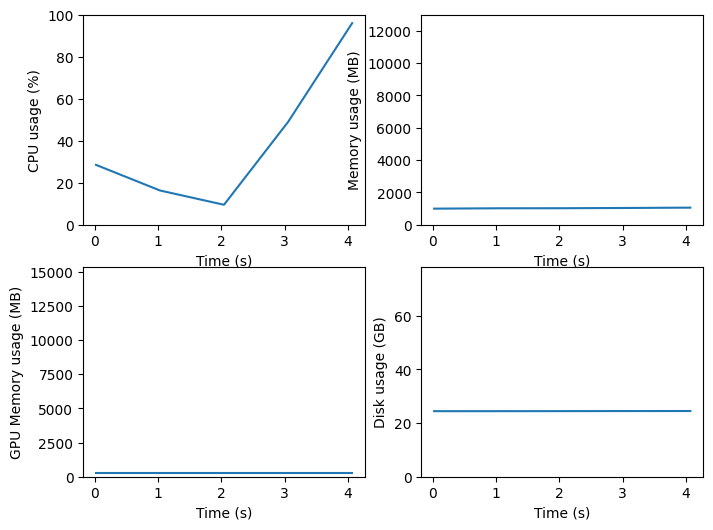

In [ ]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','total_segmentator_time','dicom_download_time','dicom_conversion_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'gpu_usage_mb', 'gpu_total_mb', 'gpu_type', 'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in SeriesInstanceUIDs:
    #for series_id in os.listdir(f'{curr_dir}/{converterType}'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(inferenceTotalSegmentator, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                gpu_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_total_mb_idx, runtime_stats.columns.get_loc('gpu_total_mb')] = [[gpu_total_mb]]

                gpu_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_usage_mb_idx, runtime_stats.columns.get_loc('gpu_usage_mb')] = [[gpu_usage_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['gpu_type']=gpu_type
                runtime_stats['disk_total']=disk_total    

                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 6)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, gpu_usage_mb)
                ax3.set_ylim(0, gpu_total_mb)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('GPU Memory usage (MB)')

                ax4.plot(time_stamps, disk_usage_all)
                ax4.set_ylim(0, disk_total)
                ax4.set_xlabel('Time (s)')
                ax4.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [ ]:
start_time = time.time()
try:
  os.remove('inferenceNiftiFiles.tar.lz4')
  os.remove('metadata.tar.lz4')
except OSError:
  pass
!tar cvf - -C {curr_dir} Inference | lz4 > inferenceNiftiFiles.tar.lz4
#!tar cvf - -C {curr_dir} metadata | lz4 > inferenceMetaData.tar.lz4
output_file_archiving_time = time.time() - start_time


Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.172787163177205374234578117444/


###Utilization Metrics

In [ ]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_file_archiving_time']=output_file_archiving_time
try:
  os.remove('inferenceUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv inferenceUsageMetrics.lz4
runtime_stats

Compressed 631 bytes into 525 bytes ==> 83.20%


,SeriesInstanceUID,total_segmentator_time,dicom_download_time,dicom_conversion_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,gpu_usage_mb,gpu_total_mb,gpu_type,disk_usage_all,disk_total,output_file_archiving_time
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.172787163177...,0,2.7226,1.925411,0,"[[[28.5, 16.3, 9.5, 49.0, 96.0]]]","[[[993.859375, 1016.48828125, 1020.03125, 1035...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[24.409114837646484, 24.409873962402344, 24....",78.189842,0.107287
